In [49]:
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import torchvision

import torch
from skimage import feature, color
from skimage.transform import resize
from skimage.feature import hog

from sklearn import svm
import time
from sklearn.metrics import classification_report,accuracy_score

from PIL import Image, ImageEnhance
from io import BytesIO

import matplotlib.pyplot as plt

In [ ]:
# !unzip -o data.zip -d .

## Loading Dataset

In [28]:
# Define the root directory where the dataset is stored
root_dir = "data"  # Update with your dataset path

# Define transformations for the images with additional augmentations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a consistent size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert image to tensor
])

# Load the training and testing datasets
train_dir = os.path.join(root_dir, "train")
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Create DataLoader objects to iterate through the dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get the class names from the dataset
class_names = train_dataset.classes
print("Classes:", class_names)

# Example of accessing images and labels from the train_loader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break  # Remove this to go through the entire dataset


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Batch of images shape: torch.Size([32, 3, 128, 128])
Batch of labels: tensor([17, 26, 24, 18,  3, 28, 23, 16,  5,  7, 27, 28, 17, 11, 13,  2, 19, 12,
         9, 16, 24, 27, 22,  9, 12,  3, 22, 15, 20, 21,  2,  1])


In [ ]:
len(train_dataset)

87000

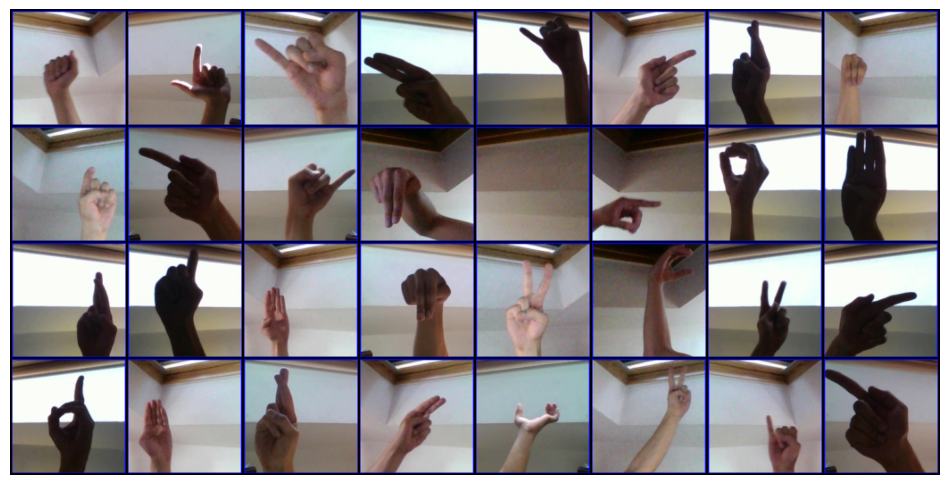

Labels:  A L J H J G R M X G J N nothing P O B R X B N V C K G D B R H space V I G


In [47]:
#Visualzing image samples

# Function to visualize a batch of images
def imshow(img, title=None):
#     img = img / 2 + 0.5  # Unnormalize the image (assuming you normalized during preprocessing)
    npimg = img.numpy()  # Convert the tensor to a NumPy array
    plt.figure(figsize=(12, 12))  # Increase the figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions to (H, W, C)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Turn off axis for a cleaner view
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels (these are indices, so class names will be mapped accordingly)
print('Labels: ', ' '.join(f'{class_names[labels[j]]}' for j in range(len(labels))))


# Model 1: HOG Feature extraction + SVM

High accuracy(99% approx.) on test set but **poor performance in real-time testing**

In [ ]:
def hog_extraction(img):
    face_gray = color.rgb2gray(img)
    resized_face = resize(face_gray, (128, 64))  # Resizing to HOG's expected input size
    ppc = 16
    fd, hog_image = hog(resized_face, orientations=8, pixels_per_cell=(ppc, ppc),
                        cells_per_block=(2, 2), visualize=True)
    return fd, hog_image

In [ ]:
# Loop over the training data and apply HOG feature extraction
hog_features = []
labels_list = []

# Iterate over the DataLoader
for images, labels in tqdm(train_loader):
    # Loop through the batch of images
    for i in range(images.size(0)):  # images.size(0) is the batch size

        # Convert the PyTorch tensor to a NumPy array
        img = images[i].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

        # Apply the HOG feature extraction
        fd, _ = hog_extraction(img)

        # Append the extracted HOG features and corresponding label
        hog_features.append(fd)
        labels_list.append(labels[i].item())

# Convert the lists to NumPy arrays for further use
hog_features = np.array(hog_features)
labels_list = np.array(labels_list)

print(f"Extracted HOG features for {hog_features.shape[0]} images.")


100%|███████████████████████████████████████| 2719/2719 [12:02<00:00,  3.76it/s]


Extracted HOG features for 87000 images.


In [ ]:
# #Save the hog features and corresponding labels

# os.makedirs("hog_features", exist_ok=True)  # Create the directory if it doesn't exist

# # Save the HOG features and labels list as .npy files
# np.save(os.path.join("hog_features", "hog_features.npy"), hog_features)
# np.save(os.path.join("hog_features", "labels_list.npy"), labels_list)

# print("HOG features and labels saved successfully in 'hog_features' folder.")

HOG features and labels saved successfully in 'hog_features' folder.


In [30]:
# # Load the HOG features and labels list
# hog_features = np.load("hog_features/hog_features.npy")
# labels_list = np.load("hog_features/labels_list.npy")

# print(f"Loaded HOG features of shape: {hog_features.shape}")
# print(f"Loaded labels list of shape: {labels_list.shape}")

Loaded HOG features of shape: (87000, 672)
Loaded labels list of shape: (87000,)


In [32]:
#Create a list `l` that maps each label in `labels_list` to its corresponding class name
l=[]
for j in range(len(labels_list)):
    l.append(class_names[labels_list[j]])

In [34]:
from sklearn.model_selection import train_test_split

# Split the HOG features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, l, test_size=0.2, random_state=42, stratify=labels_list
)

# Print the shapes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 69600 images
Testing set size: 17400 images


In [16]:
#Model definition
svm_classifier = svm.SVC(kernel='poly',degree=6)

In [17]:
#Training 
start_time = time.time()

svm_classifier.fit(X_train,y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  995.369756937027


In [18]:
# import pickle

# # Save the model to a file
# with open('svm_classifier.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)

In [36]:
# import pickle
# with open('svm_classifier.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [38]:
#Prediction on test set
y_pred = svm_classifier.predict(X_test)

In [39]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.997816091954023


              precision    recall  f1-score   support

           A       1.00      0.99      0.99       600
           B       1.00      1.00      1.00       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       0.99      0.99      0.99       600
           F       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      1.00      1.00       600
           J       1.00      1.00      1.00       600
           K       1.00      1.00      1.00       600
           L       1.00      1.00      1.00       600
           M       1.00      1.00      1.00       600
           N       1.00      1.00      1.00       600
           O       1.00      1.00      1.00       600
           P       1.00      1.00      1.00       600
           Q       1.00      1.00      1.00       6

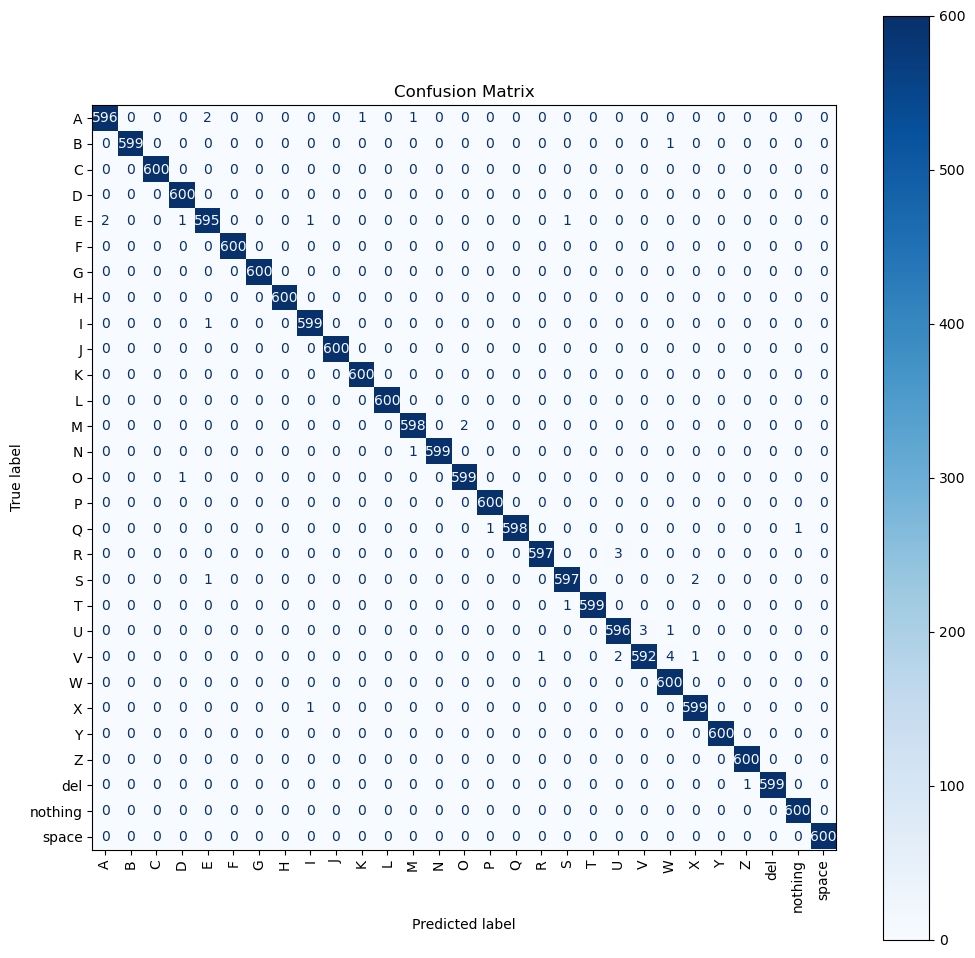

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find the unique labels in both testLabels and y_pred
all_labels = np.unique(np.concatenate([y_test, y_pred]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Create a large figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Set the desired figure size

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

# Plot with rotated x-axis labels to avoid overlap
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Set a title
plt.title('Confusion Matrix')
plt.show()


In [23]:
#Real time testing

import cv2
import mediapipe as mp
import numpy as np
from sklearn.svm import SVC
from skimage import color
from skimage.transform import resize
from skimage.feature import hog

def hog_extraction(img):
    face_gray = color.rgb2gray(img)
    resized_face = resize(face_gray, (128, 64))  # Resizing to HOG's expected input size
    ppc = 16
    fd, hog_image = hog(resized_face, orientations=8, pixels_per_cell=(ppc, ppc),
                        cells_per_block=(2, 2), visualize=True)
    return fd

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define padding value (adjust as needed)
padding = 20  # Increase or decrease this value for more or less padding

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame and detect hands
    results = hands.process(rgb_frame)

    # Draw bounding box around detected hands
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand coordinates
            h, w, _ = frame.shape
            x_min = int(min([landmark.x for landmark in hand_landmarks.landmark]) * w)
            x_max = int(max([landmark.x for landmark in hand_landmarks.landmark]) * w)
            y_min = int(min([landmark.y for landmark in hand_landmarks.landmark]) * h)
            y_max = int(max([landmark.y for landmark in hand_landmarks.landmark]) * h)

            # Add padding to the bounding box
            x_min = max(0, x_min - padding)
            x_max = min(w, x_max + padding)
            y_min = max(0, y_min - padding)
            y_max = min(h, y_max + padding)

            # Draw the rectangle around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # Extract the hand ROI
            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size > 0:  # Ensure the ROI is valid
                # Extract HOG features
                hog_features = hog_extraction(hand_roi)

                # Make a prediction using the SVM classifier
                prediction = svm_classifier.predict([hog_features])[0]

                # Display the prediction below the rectangle
                cv2.putText(frame, f'Prediction: {prediction}', (x_min, y_max + 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with the bounding box around the hand and prediction
    cv2.imshow('Hand Detection', frame)

    # Press 'q' to exit the webcam window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1732407540.089035 1425208 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732407540.116537 1492996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732407540.126773 1492994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732407544.634384 1492999 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
 

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

# Model 2: Mediapipe hand landmarks feature extraction(only angle features) + SVM

High accuracy(92% approx.) on test set and good performance in real-time testing

In real-time resting, it fails to predict E,I,K,R,T,U,X and Z correctly.

In [5]:
# Feature Extraction Code

import mediapipe as mp
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)
mp_drawing = mp.solutions.drawing_utils

# Helper function to calculate angles between vectors
def calculate_angle(pointA, pointB, pointC):
    """
    Calculate the angle at pointB formed by vectors BA and BC.
    """
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
    return np.degrees(angle)

# Initialize storage for features and labels
features = []  # List of arrays, where each array is the feature vector for one image
labels = []    # List of corresponding labels

# Iterate through DataLoader with tqdm for progress tracking
for images, batch_labels in tqdm(train_loader, desc="Processing Images", total=len(train_loader)):
    for image, label in zip(images, batch_labels):
        # Convert tensor to PIL image
        pil_image = transforms.ToPILImage()(image)

        # Prepare image for MediaPipe (convert to RGB)
        rgb_image = np.array(pil_image.convert("RGB"))

        # Perform hand pose estimation
        results = hands.process(rgb_image)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract keypoints
                keypoints = [
                    [lm.x * pil_image.width, lm.y * pil_image.height, lm.z]
                    for lm in hand_landmarks.landmark
                ]

                # Compute angles for all fingers
                finger_angles = []

                # Index finger
                finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # PIP joint

                # Middle finger
                finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # PIP joint

                # Ring finger
                finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # PIP joint

                # Pinky finger
                finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # PIP joint

                # Thumb
                finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Base joint
                finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Tip joint

                # Compute inter-finger angles
                inter_finger_angles = []
                inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb to index
                inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index to middle
                inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle to ring

                # Combine all features into a single feature vector
                feature_vector = np.array(finger_angles + inter_finger_angles )
                features.append(feature_vector)
                labels.append(label.item())  # Store label as integer

# Convert features and labels to NumPy arrays for SVM training
features = np.array(features)  # Shape: (number_of_images, number_of_features)
labels = np.array(labels)      # Shape: (number_of_images,)

# Print shapes for verification
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


I0000 00:00:1733000369.653355 4836669 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
Processing Images:   0%|                               | 0/2719 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733000369.699056 4838051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733000369.714158 4838051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733000369.895436 4838050 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Processing Images: 100%|██████████████████| 2719/2719 [1:01:35<00:00,  1.36s/it]

Features shape: (68739, 13)
Labels shape: (68739,)


In [51]:
# #Save the extracted features and corresponding labels

# os.makedirs("only_angle_features", exist_ok=True)  # Create the directory if it doesn't exist

# # Save the features and labels list as .npy files
# np.save(os.path.join("only_angle_features", "features.npy"), features)
# np.save(os.path.join("only_angle_features", "labels.npy"), labels)

# print("Angle features and labels saved successfully in 'only_angle_features' folder.")

# # Load the features and labels list
# features = np.load("only_angle_features/features.npy")
# labels = np.load("only_angle_features/labels.npy")

# print(f"Loaded features of shape: {features.shape}")
# print(f"Loaded labels of shape: {labels.shape}")

Loaded features of shape: (68766, 13)
Loaded labels of shape: (68766,)


In [53]:
#Create a list `l` that maps each label in `labels_list` to its corresponding class name
l=[]
for j in range(len(labels)):
    l.append(class_names[labels[j]])

from sklearn.model_selection import train_test_split

# Split the HOG features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, l, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 55012 images
Testing set size: 13754 images


In [55]:
from collections import Counter

# Count each distinct label
label_counts = Counter(l)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: R, Count: 2630
Label: F, Count: 2926
Label: I, Count: 2570
Label: K, Count: 2776
Label: J, Count: 2747
Label: X, Count: 2338
Label: V, Count: 2605
Label: S, Count: 2701
Label: G, Count: 2642
Label: L, Count: 2696
Label: Y, Count: 2664
Label: M, Count: 2074
Label: T, Count: 2469
Label: D, Count: 2728
Label: Z, Count: 2501
Label: A, Count: 2371
Label: O, Count: 2454
Label: Q, Count: 2348
Label: U, Count: 2589
Label: P, Count: 2205
Label: W, Count: 2568
Label: B, Count: 2298
Label: del, Count: 2077
Label: N, Count: 1581
Label: space, Count: 2078
Label: E, Count: 2387
Label: C, Count: 2186
Label: H, Count: 2537
Label: nothing, Count: 20


In [7]:
#Model training
svm_classifier = svm.SVC(kernel='poly',degree=6)

start_time = time.time()

svm_classifier.fit(X_train,y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  731.8537452220917


In [8]:
# #save trained model
# import pickle

# # Save the model to a file
# with open('svm_only_angle_features.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)

# #load trained model
# import pickle
# with open('svm_only_angle_features.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

In [9]:
#Prediction on test set
y_pred = svm_classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9202793133546697


              precision    recall  f1-score   support

           A       0.97      0.97      0.97       474
           B       0.98      0.98      0.98       459
           C       0.86      0.95      0.90       436
           D       0.95      0.96      0.96       545
           E       0.95      0.97      0.96       479
           F       0.99      0.98      0.98       588
           G       0.95      0.96      0.96       529
           H       0.84      0.84      0.84       507
           I       0.85      0.83      0.84       514
           J       0.85      0.86      0.86       550
           K       0.96      0.98      0.97       555
           L       0.99      0.97      0.98       539
           M       0.77      0.83      0.80       410
           N       0.89      0.76      0.82       315
           O       0.96      0.95      0.95       492
           P       0.93      0.95      0.94       442
           Q       0.95      0.87      0.91       

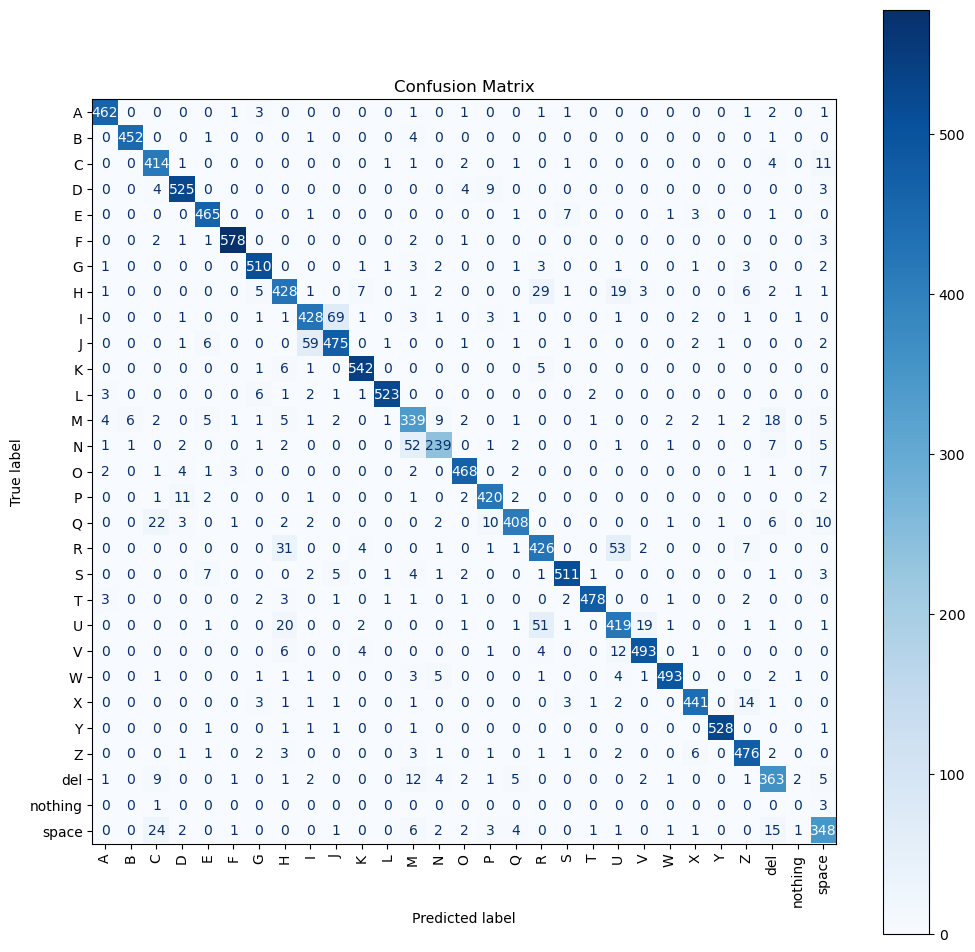

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find the unique labels in both testLabels and y_pred
all_labels = np.unique(np.concatenate([y_test, y_pred]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Create a large figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Set the desired figure size

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

# Plot with rotated x-axis labels to avoid overlap
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Set a title
plt.title('Confusion Matrix')
plt.show()

In [17]:
#Real-time Testing

import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Function to calculate angle between vectors
def calculate_angle(pointA, pointB, pointC):
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define padding value
padding = 20

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame and detect hands
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand coordinates
            h, w, _ = frame.shape
            keypoints = [
                [landmark.x * w, landmark.y * h, landmark.z]
                for landmark in hand_landmarks.landmark
            ]

            # Compute angles for all fingers
            finger_angles = []
            finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # Index MCP
            finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # Index PIP
            finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # Middle MCP
            finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # Middle PIP
            finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # Ring MCP
            finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # Ring PIP
            finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # Pinky MCP
            finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # Pinky PIP
            finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Thumb base
            finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Thumb tip

            # Compute inter-finger angles
            inter_finger_angles = []
            inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb-Index
            inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index-Middle
            inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle-Ring

            # Combine all features into a single feature vector
            feature_vector = np.array(finger_angles + inter_finger_angles)

            # Make a prediction using the SVM classifier
            prediction = svm_classifier.predict([feature_vector])[0]

            # Draw bounding box and prediction
            x_min = int(min([landmark.x for landmark in hand_landmarks.landmark]) * w) - padding
            x_max = int(max([landmark.x for landmark in hand_landmarks.landmark]) * w) + padding
            y_min = int(min([landmark.y for landmark in hand_landmarks.landmark]) * h) - padding
            y_max = int(max([landmark.y for landmark in hand_landmarks.landmark]) * h) + padding

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(frame, f'Prediction: {prediction}', (x_min, y_max + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with the bounding box around the hand and prediction
    cv2.imshow('Hand Detection', frame)

    # Press 'q' to exit the webcam window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1733010996.788851 4836669 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1733010996.812498 4942772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733010996.821244 4942774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Model 3: Mediapipe hand landmarks feature extraction(angle and distance based) + SVM

High accuracy(95% approx.) on test set but **poor performance in real-time testing**

In real-time resting, it only predicts S,T and Y correctly.

In [ ]:
# Feature Extraction Code

import mediapipe as mp
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)
mp_drawing = mp.solutions.drawing_utils

# Helper function to calculate angles between vectors
def calculate_angle(pointA, pointB, pointC):
    """
    Calculate the angle at pointB formed by vectors BA and BC.
    """
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
    return np.degrees(angle)

# Initialize storage for features and labels
features = []  # List of arrays, where each array is the feature vector for one image
labels = []    # List of corresponding labels

# Iterate through DataLoader with tqdm for progress tracking
for images, batch_labels in tqdm(train_loader, desc="Processing Images", total=len(train_loader)):
    for image, label in zip(images, batch_labels):
        # Convert tensor to PIL image
        pil_image = transforms.ToPILImage()(image)

        # Prepare image for MediaPipe (convert to RGB)
        rgb_image = np.array(pil_image.convert("RGB"))

        # Perform hand pose estimation
        results = hands.process(rgb_image)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract keypoints
                keypoints = [
                    [lm.x * pil_image.width, lm.y * pil_image.height, lm.z]
                    for lm in hand_landmarks.landmark
                ]

                # Compute angles for all fingers
                finger_angles = []

                # Index finger
                finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # PIP joint

                # Middle finger
                finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # PIP joint

                # Ring finger
                finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # PIP joint

                # Pinky finger
                finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # PIP joint

                # Thumb
                finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Base joint
                finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Tip joint

                # Compute inter-finger angles
                inter_finger_angles = []
                inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb to index
                inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index to middle
                inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle to ring


                # Compute distances from wrist to each fingertip
                distances = []
                distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[4])))  # Wrist to thumb tip
                distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[8])))  # Wrist to index tip
                distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[12])))  # Wrist to middle tip
                distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[16])))  # Wrist to ring tip
                distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[20])))  # Wrist to pinky tip

                # Combine all features into a single feature vector
                feature_vector = np.array(finger_angles + inter_finger_angles + distances)
                features.append(feature_vector)
                labels.append(label.item())  # Store label as integer

# Convert features and labels to NumPy arrays for SVM training
features = np.array(features)  # Shape: (number_of_images, number_of_features)
labels = np.array(labels)      # Shape: (number_of_images,)

# Print shapes for verification
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


I0000 00:00:1732049550.211234 33748981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Processing Images:   0%|                               | 0/2719 [00:00<?, ?it/s]W0000 00:00:1732049550.260640 33749558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732049550.290566 33749558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732049550.411778 33749560 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_fact

Features shape: (68690, 18)
Labels shape: (68690,)


In [4]:
# #Save the extracted features and corresponding labels

# os.makedirs("angle_and_distance_features", exist_ok=True)  # Create the directory if it doesn't exist

# # Save the HOG features and labels list as .npy files
# np.save(os.path.join("angle_and_distance_features", "features.npy"), features)
# np.save(os.path.join("angle_and_distance_features", "labels.npy"), labels)

# print("Angle and Distance features and labels saved successfully in 'angle_and_distance_features' folder.")

In [57]:
# # Load the features and labels list
# features = np.load("angle_and_distance_features/features.npy")
# labels = np.load("angle_and_distance_features/labels.npy")

# print(f"Loaded features of shape: {features.shape}")
# print(f"Loaded labels of shape: {labels.shape}")

Loaded features of shape: (68690, 18)
Loaded labels of shape: (68690,)


In [59]:
#Create a list `l` that maps each label in `labels_list` to its corresponding class name
l=[]
for j in range(len(labels)):
    l.append(class_names[labels[j]])

from sklearn.model_selection import train_test_split

# Split the HOG features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, l, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 54952 images
Testing set size: 13738 images


In [61]:
from collections import Counter

# Count each distinct label
label_counts = Counter(l)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: J, Count: 2744
Label: G, Count: 2642
Label: Y, Count: 2666
Label: F, Count: 2930
Label: W, Count: 2558
Label: U, Count: 2589
Label: D, Count: 2723
Label: C, Count: 2192
Label: H, Count: 2533
Label: T, Count: 2463
Label: space, Count: 2068
Label: P, Count: 2217
Label: Z, Count: 2493
Label: E, Count: 2396
Label: O, Count: 2449
Label: X, Count: 2348
Label: M, Count: 2057
Label: L, Count: 2694
Label: V, Count: 2608
Label: K, Count: 2768
Label: N, Count: 1573
Label: A, Count: 2367
Label: R, Count: 2624
Label: S, Count: 2697
Label: I, Count: 2572
Label: del, Count: 2058
Label: B, Count: 2293
Label: Q, Count: 2346
Label: nothing, Count: 22


In [ ]:
#Model Training
svm_classifier = svm.SVC(kernel='poly',degree=6)

start_time = time.time()

svm_classifier.fit(X_train,y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  24.40465998649597


In [38]:
# #save trained model
# import pickle

# # Save the model to a file
# with open('svm_angle_and_distance_features.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)

# #load trained model
# import pickle
# with open('svm_angle_and_distance_features.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

In [8]:
#Prediction on test set
y_pred = svm_classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.95181249090115


              precision    recall  f1-score   support

           A       0.96      0.99      0.97       473
           B       0.99      1.00      0.99       459
           C       0.93      0.97      0.95       438
           D       0.98      0.97      0.97       545
           E       0.98      0.99      0.99       479
           F       0.99      0.99      0.99       586
           G       0.99      0.98      0.99       528
           H       0.93      0.92      0.93       507
           I       0.87      0.84      0.86       514
           J       0.86      0.90      0.88       549
           K       0.99      0.98      0.98       554
           L       0.99      0.99      0.99       539
           M       0.84      0.91      0.87       411
           N       0.92      0.84      0.88       315
           O       0.98      0.99      0.98       490
           P       0.96      0.95      0.96       443
           Q       0.95      0.93      0.94       46

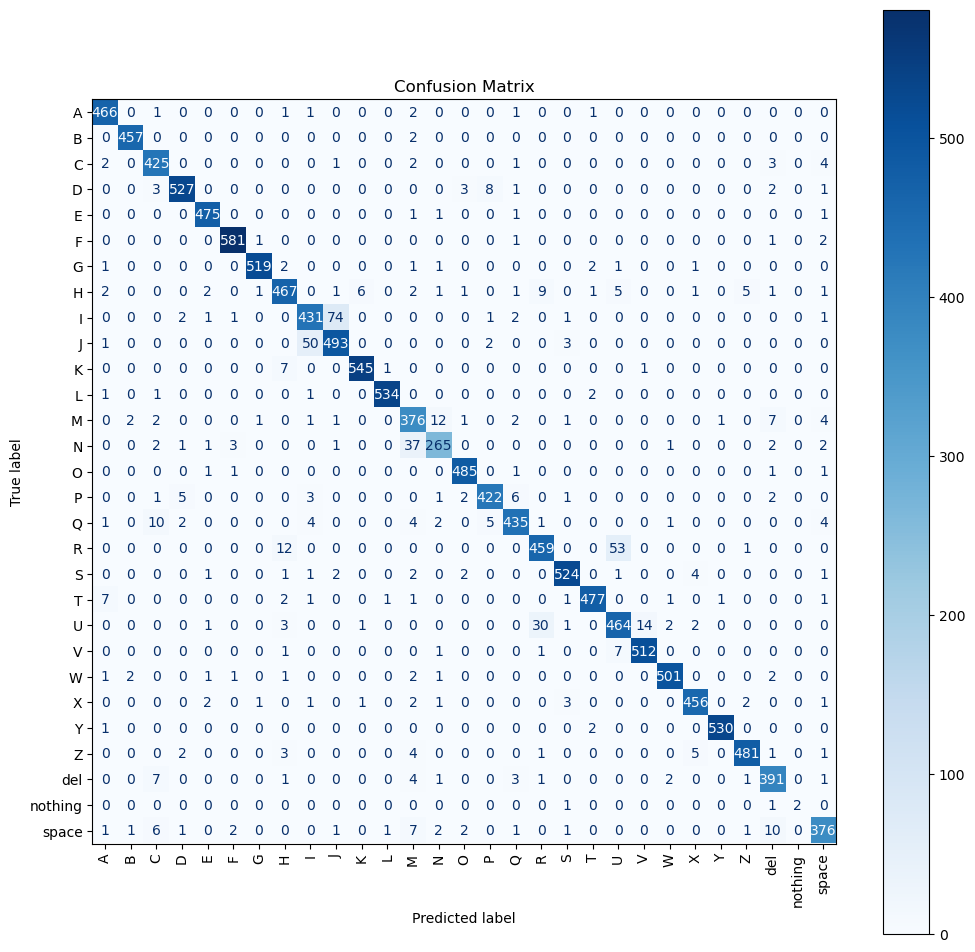

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find the unique labels in both testLabels and y_pred
all_labels = np.unique(np.concatenate([y_test, y_pred]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Create a large figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Set the desired figure size

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

# Plot with rotated x-axis labels to avoid overlap
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Set a title
plt.title('Confusion Matrix')
plt.show()

In [2]:
#Real-time Testing

import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Function to calculate angle between vectors
def calculate_angle(pointA, pointB, pointC):
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define padding value
padding = 20

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame and detect hands
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand coordinates
            h, w, _ = frame.shape
            keypoints = [
                [landmark.x * w, landmark.y * h, landmark.z]
                for landmark in hand_landmarks.landmark
            ]

            # Compute angles for all fingers
            finger_angles = []
            finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # Index MCP
            finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # Index PIP
            finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # Middle MCP
            finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # Middle PIP
            finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # Ring MCP
            finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # Ring PIP
            finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # Pinky MCP
            finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # Pinky PIP
            finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Thumb base
            finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Thumb tip

            # Compute inter-finger angles
            inter_finger_angles = []
            inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb-Index
            inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index-Middle
            inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle-Ring

            # Compute distances from wrist to fingertips
            distances = []
            distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[4])))  # Wrist to thumb tip
            distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[8])))  # Wrist to index tip
            distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[12])))  # Wrist to middle tip
            distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[16])))  # Wrist to ring tip
            distances.append(np.linalg.norm(np.array(keypoints[0]) - np.array(keypoints[20])))  # Wrist to pinky tip

            # Combine all features into a single feature vector
            feature_vector = np.array(finger_angles + inter_finger_angles + distances)

            # Make a prediction using the SVM classifier
            prediction = svm_classifier.predict([feature_vector])[0]

            # Draw bounding box and prediction
            x_min = int(min([landmark.x for landmark in hand_landmarks.landmark]) * w) - padding
            x_max = int(max([landmark.x for landmark in hand_landmarks.landmark]) * w) + padding
            y_min = int(min([landmark.y for landmark in hand_landmarks.landmark]) * h) - padding
            y_max = int(max([landmark.y for landmark in hand_landmarks.landmark]) * h) + padding

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(frame, f'Prediction: {prediction}', (x_min, y_max + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with the bounding box around the hand and prediction
    cv2.imshow('Hand Detection', frame)

    # Press 'q' to exit the webcam window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1732473724.855079 1494486 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732473724.878363 1878832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732473724.889452 1878832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732473728.452819 1878831 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
 

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

# Model 4: Mediapipe hand landmarks feature extraction(angles and finger curls) + SVM

High accuracy(91%) on test set and **high performance in real-time testing**

Real-time testing failure points- alphabets: I,R,U

In [ ]:
# Feature Extraction Code

import mediapipe as mp
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)
mp_drawing = mp.solutions.drawing_utils

# Helper function to calculate angles between vectors
def calculate_angle(pointA, pointB, pointC):
    """
    Calculate the angle at pointB formed by vectors BA and BC.
    """
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
    return np.degrees(angle)

# Helper function to calculate finger curl
def calculate_curl(base, pip, tip):
    """
    Calculate the curl of a finger.
    base: MCP joint of the finger
    pip: PIP joint of the finger
    tip: Tip of the finger
    Curl is calculated as the ratio of the distances: (base to tip) / (base to pip)
    """
    distance_base_to_tip = np.linalg.norm(np.array(tip) - np.array(base))
    distance_base_to_pip = np.linalg.norm(np.array(pip) - np.array(base))
    return distance_base_to_tip / distance_base_to_pip

# Initialize storage for features and labels
features = []  # List of arrays, where each array is the feature vector for one image
labels = []    # List of corresponding labels

# Iterate through DataLoader with tqdm for progress tracking
for images, batch_labels in tqdm(train_loader, desc="Processing Images", total=len(train_loader)):
    for image, label in zip(images, batch_labels):
        # Convert tensor to PIL image
        pil_image = transforms.ToPILImage()(image)

        # Prepare image for MediaPipe (convert to RGB)
        rgb_image = np.array(pil_image.convert("RGB"))

        # Perform hand pose estimation
        results = hands.process(rgb_image)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract keypoints
                keypoints = [
                    [lm.x * pil_image.width, lm.y * pil_image.height, lm.z]
                    for lm in hand_landmarks.landmark
                ]

                # Compute angles for all fingers
                finger_angles = []

                # Index finger
                finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # PIP joint

                # Middle finger
                finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # PIP joint

                # Ring finger
                finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # PIP joint

                # Pinky finger
                finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # PIP joint

                # Thumb
                finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Base joint
                finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Tip joint

                # Compute inter-finger angles
                inter_finger_angles = []
                inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb to index
                inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index to middle
                inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle to ring

                # Compute finger curl
                finger_curls = []
                finger_curls.append(calculate_curl(keypoints[0], keypoints[1], keypoints[4]))  # Thumb curl
                finger_curls.append(calculate_curl(keypoints[5], keypoints[6], keypoints[8]))  # Index curl
                finger_curls.append(calculate_curl(keypoints[9], keypoints[10], keypoints[12]))  # Middle curl
                finger_curls.append(calculate_curl(keypoints[13], keypoints[14], keypoints[16]))  # Ring curl
                finger_curls.append(calculate_curl(keypoints[17], keypoints[18], keypoints[20]))  # Pinky curl

                # Combine all features into a single feature vector
                feature_vector = np.array(finger_angles + inter_finger_angles + finger_curls)
                features.append(feature_vector)
                labels.append(label.item())  # Store label as integer

# Convert features and labels to NumPy arrays for SVM training
features = np.array(features)  # Shape: (number_of_images, number_of_features)
labels = np.array(labels)      # Shape: (number_of_images,)

# Print shapes for verification
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


In [ ]:
# #Save the extracted features and corresponding labels

# os.makedirs("angle_and_fingercurl_features", exist_ok=True)  # Create the directory if it doesn't exist
# np.save(os.path.join("angle_and_fingercurl_features", "features.npy"), features)
# np.save(os.path.join("angle_and_fingercurl_features", "labels.npy"), labels)

# print("Angle and Finger curl features and labels saved successfully in 'angle_and_fingercurl_features' folder.")

In [12]:
# # Load the features and labels list
# features = np.load("angle_and_fingercurl_features/features.npy")
# labels = np.load("angle_and_fingercurl_features/labels.npy")

# print(f"Loaded features of shape: {features.shape}")
# print(f"Loaded labels of shape: {labels.shape}")

Loaded features of shape: (68719, 18)
Loaded labels of shape: (68719,)


In [13]:
#Create a list `l` that maps each label in `labels_list` to its corresponding class name
l=[]
for j in range(len(labels)):
    l.append(class_names[labels[j]])

from sklearn.model_selection import train_test_split

# Split the HOG features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, l, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 54975 images
Testing set size: 13744 images


In [14]:
from collections import Counter

# Count each distinct label
label_counts = Counter(l)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: T, Count: 2474
Label: Y, Count: 2669
Label: P, Count: 2227
Label: D, Count: 2726
Label: B, Count: 2288
Label: F, Count: 2932
Label: O, Count: 2439
Label: W, Count: 2562
Label: I, Count: 2572
Label: U, Count: 2586
Label: H, Count: 2534
Label: X, Count: 2341
Label: R, Count: 2623
Label: K, Count: 2769
Label: C, Count: 2183
Label: J, Count: 2742
Label: G, Count: 2641
Label: A, Count: 2374
Label: Z, Count: 2494
Label: S, Count: 2697
Label: L, Count: 2694
Label: Q, Count: 2358
Label: N, Count: 1587
Label: space, Count: 2083
Label: E, Count: 2393
Label: M, Count: 2052
Label: V, Count: 2606
Label: del, Count: 2056
Label: nothing, Count: 17


In [ ]:
#Model Training
svm_classifier = svm.SVC(kernel='poly',degree=6)

start_time = time.time()

svm_classifier.fit(X_train,y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  19.489870071411133


In [11]:
# #save trained model
# import pickle

# # Save the model to a file
# with open('svm_angle_and_fingercurl_features.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)

# #load trained model
# import pickle
# with open('svm_angle_and_fingercurl_features.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

In [ ]:
#Prediction on test set
y_pred = svm_classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9117433061699651


              precision    recall  f1-score   support

           A       0.96      0.97      0.96       475
           B       0.98      1.00      0.99       458
           C       0.86      0.93      0.89       437
           D       0.97      0.97      0.97       545
           E       0.96      0.97      0.96       479
           F       0.99      0.97      0.98       587
           G       0.98      0.95      0.96       528
           H       0.81      0.79      0.80       507
           I       0.80      0.74      0.77       514
           J       0.80      0.81      0.80       548
           K       0.92      0.95      0.94       554
           L       0.99      0.98      0.98       539
           M       0.80      0.87      0.83       410
           N       0.89      0.77      0.83       317
           O       0.95      0.97      0.96       488
           P       0.95      0.96      0.95       445
           Q       0.94      0.88      0.90       

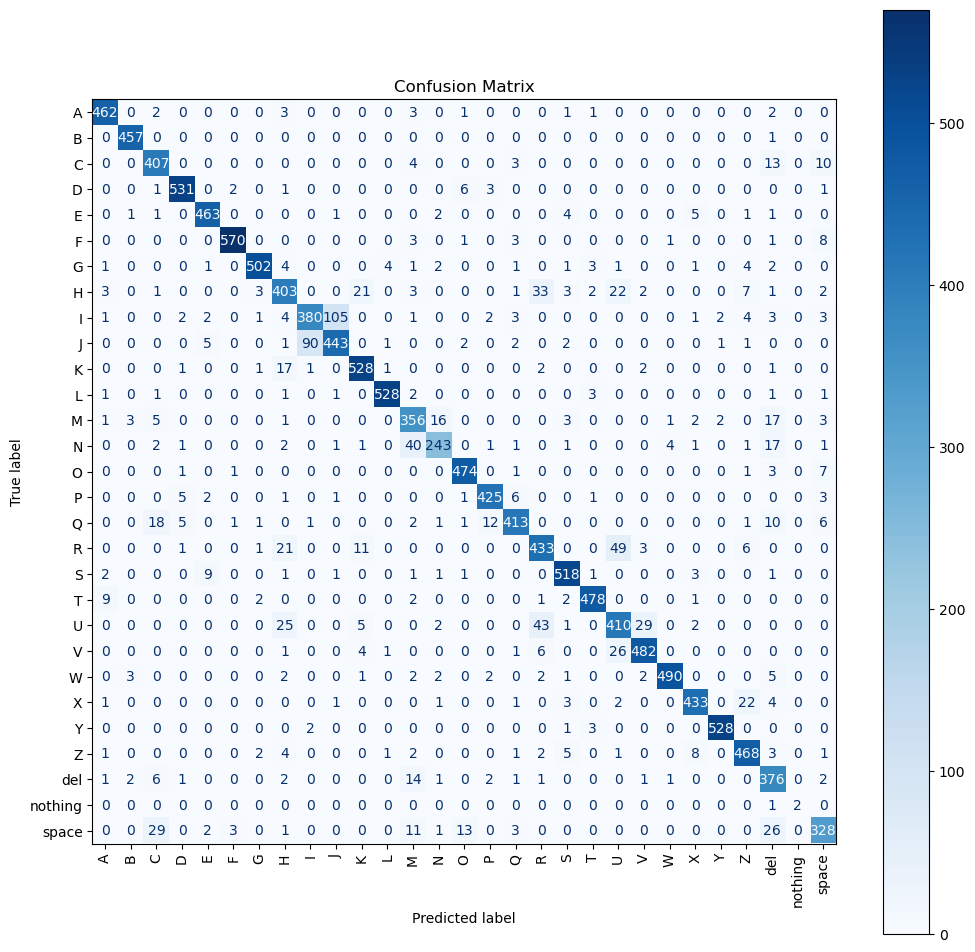

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find the unique labels in both testLabels and y_pred
all_labels = np.unique(np.concatenate([y_test, y_pred]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Create a large figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Set the desired figure size

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

# Plot with rotated x-axis labels to avoid overlap
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Set a title
plt.title('Confusion Matrix')
plt.show()


In [4]:
#Real-time Testing

import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Function to calculate angle between vectors
def calculate_angle(pointA, pointB, pointC):
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# Function to calculate finger curl
def calculate_curl(base, pip, tip):
    distance_base_to_tip = np.linalg.norm(np.array(tip) - np.array(base))
    distance_base_to_pip = np.linalg.norm(np.array(pip) - np.array(base))
    return distance_base_to_tip / distance_base_to_pip

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define padding value
padding = 20

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame and detect hands
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand coordinates
            h, w, _ = frame.shape
            keypoints = [
                [landmark.x * w, landmark.y * h, landmark.z]
                for landmark in hand_landmarks.landmark
            ]

            # Compute angles for all fingers
            finger_angles = []
            finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # Index MCP
            finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # Index PIP
            finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # Middle MCP
            finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # Middle PIP
            finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # Ring MCP
            finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # Ring PIP
            finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # Pinky MCP
            finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # Pinky PIP
            finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Thumb base
            finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Thumb tip

            # Compute inter-finger angles
            inter_finger_angles = []
            inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb-Index
            inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index-Middle
            inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle-Ring

            # Compute finger curl
            finger_curls = []
            finger_curls.append(calculate_curl(keypoints[0], keypoints[1], keypoints[4]))  # Thumb curl
            finger_curls.append(calculate_curl(keypoints[5], keypoints[6], keypoints[8]))  # Index curl
            finger_curls.append(calculate_curl(keypoints[9], keypoints[10], keypoints[12]))  # Middle curl
            finger_curls.append(calculate_curl(keypoints[13], keypoints[14], keypoints[16]))  # Ring curl
            finger_curls.append(calculate_curl(keypoints[17], keypoints[18], keypoints[20]))  # Pinky curl

            # Combine all features into a single feature vector
            feature_vector = np.array(finger_angles + inter_finger_angles + finger_curls)

            # Make a prediction using the SVM classifier
            prediction = svm_classifier.predict([feature_vector])[0]

            # Draw bounding box and prediction
            x_min = int(min([landmark.x for landmark in hand_landmarks.landmark]) * w) - padding
            x_max = int(max([landmark.x for landmark in hand_landmarks.landmark]) * w) + padding
            y_min = int(min([landmark.y for landmark in hand_landmarks.landmark]) * h) - padding
            y_max = int(max([landmark.y for landmark in hand_landmarks.landmark]) * h) + padding

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(frame, f'Prediction: {prediction}', (x_min, y_max + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with the bounding box around the hand and prediction
    cv2.imshow('Hand Detection', frame)

    # Press 'q' to exit the webcam window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1732112922.456631 34049408 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732112922.486972 34050501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732112922.497641 34050501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732112932.266615 34050506 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soo

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/

# Model 5: Mediapipe angle+finger curl+palm orientation features

High accuracy(94.88%) on test set and high performance in real-time testing

In real-time resting, it predicts all of the letters correctly.

In [ ]:
# Feature Extraction Code

import mediapipe as mp
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Helper function to calculate angles between vectors
def calculate_angle(pointA, pointB, pointC):
    """
    Calculate the angle at pointB formed by vectors BA and BC.
    """
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
    return np.degrees(angle)

# Helper function to calculate finger curl
def calculate_curl(base, pip, tip):
    """
    Calculate the curl of a finger.
    base: MCP joint of the finger
    pip: PIP joint of the finger
    tip: Tip of the finger
    Curl is calculated as the ratio of the distances: (base to tip) / (base to pip)
    """
    distance_base_to_tip = np.linalg.norm(np.array(tip) - np.array(base))
    distance_base_to_pip = np.linalg.norm(np.array(pip) - np.array(base))
    return distance_base_to_tip / distance_base_to_pip

# Helper function to calculate palm orientation
def calculate_palm_orientation(wrist, middle_mcp, pinky_mcp):
    """
    Calculate the orientation of the palm using vectors.
    wrist: Wrist landmark (keypoints[0])
    middle_mcp: Middle finger MCP joint (keypoints[9])
    pinky_mcp: Pinky finger MCP joint (keypoints[17])
    Returns roll, pitch, yaw angles in degrees.
    """
    # Create vectors
    wrist_to_middle = np.array(middle_mcp) - np.array(wrist)
    wrist_to_pinky = np.array(pinky_mcp) - np.array(wrist)

    # Normal vector to the palm plane (cross product)
    palm_normal = np.cross(wrist_to_middle, wrist_to_pinky)
    palm_normal /= np.linalg.norm(palm_normal)  # Normalize

    # Calculate roll (rotation around x-axis)
    roll = np.arctan2(palm_normal[1], palm_normal[2])

    # Calculate pitch (rotation around y-axis)
    pitch = np.arctan2(-palm_normal[0], np.sqrt(palm_normal[1]**2 + palm_normal[2]**2))

    # Calculate yaw (rotation around z-axis)
    yaw = np.arctan2(wrist_to_middle[1], wrist_to_middle[0])

    # Convert to degrees
    roll = np.degrees(roll)
    pitch = np.degrees(pitch)
    yaw = np.degrees(yaw)

    return roll, pitch, yaw

# Initialize storage for features and labels
features = []  # List of arrays, where each array is the feature vector for one image
labels = []    # List of corresponding labels

# Iterate through DataLoader with tqdm for progress tracking
for images, batch_labels in tqdm(train_loader, desc="Processing Images", total=len(train_loader)):
    for image, label in zip(images, batch_labels):
        # Convert tensor to PIL image
        pil_image = transforms.ToPILImage()(image)

        # Prepare image for MediaPipe (convert to RGB)
        rgb_image = np.array(pil_image.convert("RGB"))

        # Perform hand pose estimation
        results = hands.process(rgb_image)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract keypoints
                keypoints = [
                    [lm.x * pil_image.width, lm.y * pil_image.height, lm.z]
                    for lm in hand_landmarks.landmark
                ]

                # Compute angles for all fingers
                finger_angles = []

                # Index finger
                finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # PIP joint

                # Middle finger
                finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # PIP joint

                # Ring finger
                finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # PIP joint

                # Pinky finger
                finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # MCP joint
                finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # PIP joint

                # Thumb
                finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Base joint
                finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Tip joint

                # Compute inter-finger angles
                inter_finger_angles = []
                inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb to index
                inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index to middle
                inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle to ring

                # Compute finger curl
                finger_curls = []
                finger_curls.append(calculate_curl(keypoints[0], keypoints[1], keypoints[4]))  # Thumb curl
                finger_curls.append(calculate_curl(keypoints[5], keypoints[6], keypoints[8]))  # Index curl
                finger_curls.append(calculate_curl(keypoints[9], keypoints[10], keypoints[12]))  # Middle curl
                finger_curls.append(calculate_curl(keypoints[13], keypoints[14], keypoints[16]))  # Ring curl
                finger_curls.append(calculate_curl(keypoints[17], keypoints[18], keypoints[20]))  # Pinky curl

                # Compute palm orientation
                roll, pitch, yaw = calculate_palm_orientation(
                    keypoints[0], keypoints[9], keypoints[17]
                )

                # Combine all features into a single feature vector
                feature_vector = np.array(finger_angles + inter_finger_angles + finger_curls + [roll, pitch, yaw])
                features.append(feature_vector)
                labels.append(label.item())  # Store label as integer

# Convert features and labels to NumPy arrays for SVM training
features = np.array(features)  # Shape: (number_of_images, number_of_features)
labels = np.array(labels)      # Shape: (number_of_images,)

# Print shapes for verification
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


I0000 00:00:1732061263.436421 33831645 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732061263.451144 33854154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732061263.463522 33854154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Images:   0%|                               | 0/2719 [00:00<?, ?it/s]W0000 00:00:1732061263.813927 33854155 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/baibhavdatta/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_fact

Features shape: (66419, 21)
Labels shape: (66419,)


In [ ]:
# #Save the extracted features and corresponding labels

# os.makedirs("angle_fingercurl_palmorientation_features", exist_ok=True)  # Create the directory if it doesn't exist

# # Save the HOG features and labels list as .npy files
# np.save(os.path.join("angle_fingercurl_palmorientation_features", "features.npy"), features)
# np.save(os.path.join("angle_fingercurl_palmorientation_features", "labels.npy"), labels)

# print("Angle, Finger Curl and Palm Orientation features and labels saved successfully in 'angle_fingercurl_palmorientation_features' folder.")

Angle, Finger Curl and Palm Orientation features and labels saved successfully in 'angle_fingercurl_palmorientation_features' folder.


In [63]:
# # Load the features and labels list
# features = np.load("angle_fingercurl_palmorientation_features/features.npy")
# labels = np.load("angle_fingercurl_palmorientation_features/labels.npy")

# print(f"Loaded features of shape: {features.shape}")
# print(f"Loaded labels of shape: {labels.shape}")

Loaded features of shape: (66419, 21)
Loaded labels of shape: (66419,)


In [65]:
#Create a list `l` that maps each label in `labels_list` to its corresponding class name
l=[]
for j in range(len(labels)):
    l.append(class_names[labels[j]])

from sklearn.model_selection import train_test_split

# Split the HOG features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, l, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print(f"Training set size: {X_train.shape[0]} images")
print(f"Testing set size: {X_test.shape[0]} images")

Training set size: 53135 images
Testing set size: 13284 images


In [67]:
from collections import Counter

# Count each distinct label
label_counts = Counter(l)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: V, Count: 2580
Label: P, Count: 2095
Label: Q, Count: 2262
Label: B, Count: 2259
Label: A, Count: 2265
Label: I, Count: 2506
Label: U, Count: 2538
Label: D, Count: 2664
Label: T, Count: 2435
Label: F, Count: 2903
Label: H, Count: 2470
Label: J, Count: 2691
Label: W, Count: 2532
Label: K, Count: 2729
Label: S, Count: 2628
Label: R, Count: 2592
Label: del, Count: 1918
Label: space, Count: 1866
Label: O, Count: 2375
Label: C, Count: 2070
Label: L, Count: 2628
Label: G, Count: 2534
Label: Z, Count: 2431
Label: X, Count: 2252
Label: N, Count: 1351
Label: E, Count: 2364
Label: M, Count: 1823
Label: Y, Count: 2641
Label: nothing, Count: 17


In [5]:
#Model Training
svm_classifier = svm.SVC(kernel='poly',degree=6)

start_time = time.time()

svm_classifier.fit(X_train,y_train)

end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  9.630075216293335


In [41]:
# #save trained model
# import pickle

# # Save the model to a file
# with open('angle_fingercurl_palmorientation_features.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)

# #load trained model
# import pickle
# with open('angle_fingercurl_palmorientation_features.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

In [6]:
#Prediction on test set
y_pred = svm_classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9488858777476664


              precision    recall  f1-score   support

           A       0.95      0.98      0.96       453
           B       0.98      1.00      0.99       452
           C       0.93      0.98      0.95       414
           D       0.98      0.98      0.98       533
           E       0.94      0.98      0.96       473
           F       0.98      0.98      0.98       581
           G       0.99      0.99      0.99       507
           H       0.97      0.98      0.98       494
           I       0.96      0.94      0.95       501
           J       0.99      0.95      0.97       538
           K       0.95      0.98      0.96       546
           L       0.99      1.00      0.99       526
           M       0.81      0.89      0.85       365
           N       0.87      0.77      0.82       270
           O       0.96      0.98      0.97       475
           P       0.97      0.98      0.98       419
           Q       0.97      0.94      0.96       

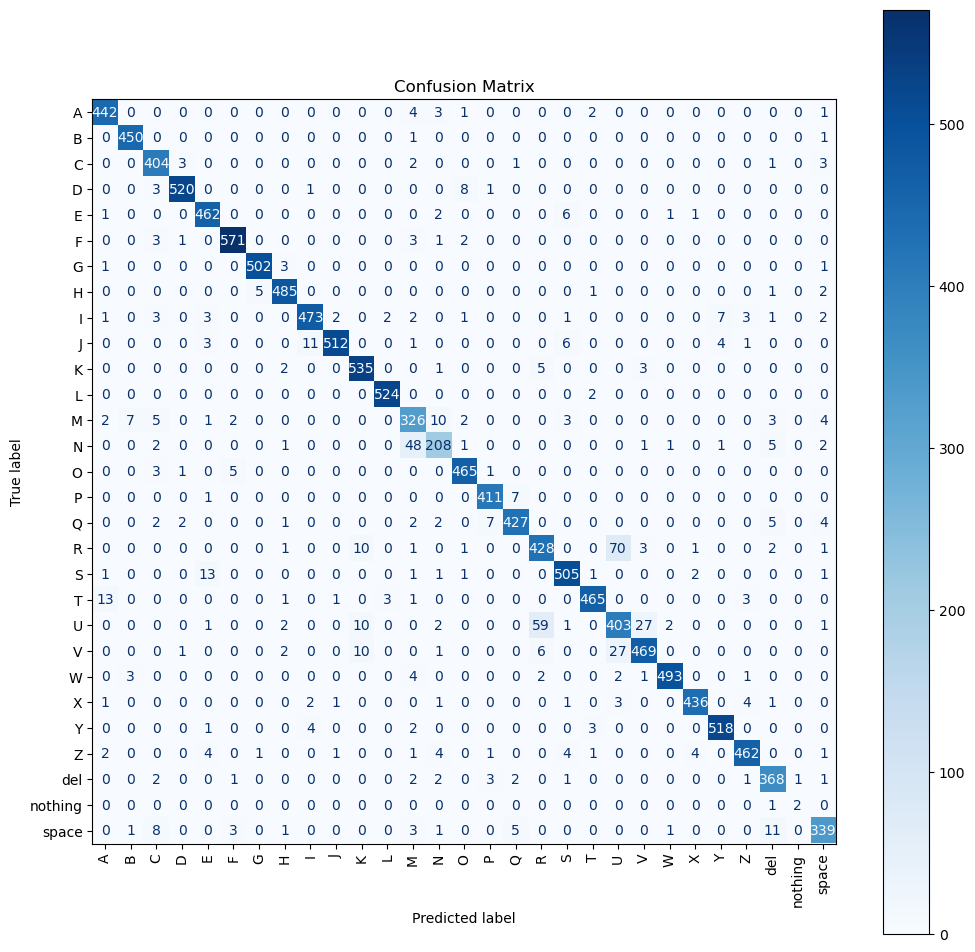

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find the unique labels in both testLabels and y_pred
all_labels = np.unique(np.concatenate([y_test, y_pred]))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Create a large figure and plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Set the desired figure size

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)

# Plot with rotated x-axis labels to avoid overlap
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')

# Set a title
plt.title('Confusion Matrix')
plt.show()


In [2]:
# #load trained model
# import pickle
# with open('angle_fingercurl_palmorientation_features.pkl', 'rb') as file:
#     svm_classifier = pickle.load(file)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
#Real-time Testing

import cv2
import mediapipe as mp
import numpy as np
import pickle  # To load the trained SVM model

# Load local images
background_img = cv2.imread('bg.jpg')  # Replace with your background image path
title_img = cv2.imread('title.jpg')  # Replace with your title image path

# Resize the title image to fit the top of the UI
title_img = cv2.resize(title_img, (600, 100))  # Adjust the dimensions as needed

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Function to calculate angle between vectors
def calculate_angle(pointA, pointB, pointC):
    BA = np.array(pointA) - np.array(pointB)
    BC = np.array(pointC) - np.array(pointB)
    dot_product = np.dot(BA, BC)
    magnitude_BA = np.linalg.norm(BA)
    magnitude_BC = np.linalg.norm(BC)
    cos_theta = dot_product / (magnitude_BA * magnitude_BC)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# Function to calculate finger curl
def calculate_curl(base, pip, tip):
    distance_base_to_tip = np.linalg.norm(np.array(tip) - np.array(base))
    distance_base_to_pip = np.linalg.norm(np.array(pip) - np.array(base))
    return distance_base_to_tip / distance_base_to_pip

# Function to calculate palm orientation (roll, pitch, yaw)
def calculate_palm_orientation(wrist, middle_mcp, pinky_mcp):
    wrist_to_middle = np.array(middle_mcp) - np.array(wrist)
    wrist_to_pinky = np.array(pinky_mcp) - np.array(wrist)

    palm_normal = np.cross(wrist_to_middle, wrist_to_pinky)
    palm_normal /= np.linalg.norm(palm_normal)

    roll = np.arctan2(palm_normal[1], palm_normal[2])
    pitch = np.arctan2(-palm_normal[0], np.sqrt(palm_normal[1]**2 + palm_normal[2]**2))
    yaw = np.arctan2(wrist_to_middle[1], wrist_to_middle[0])

    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

# Define padding and transparency
padding = 20
overlay_alpha = 0.6

# Gap between title and live feed
title_gap = 50  # Adjust the gap as needed

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Flip the frame horizontally for a later selfie-view display
    frame = cv2.flip(frame, 1)

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame and detect hands
    results = hands.process(rgb_frame)

    # Resize background to match webcam frame
    background_resized = cv2.resize(background_img, (frame.shape[1], frame.shape[0]))

    # Dimensions for components
    title_width = 600
    title_height = 100
    live_feed_width = 900
    live_feed_height = 480
    prediction_width = 600
    prediction_height = 100

    # Calculate the center positions
    title_x = (frame.shape[1] - title_width) // 2
    title_y = 20  # Place the title at the top
    live_feed_x = (frame.shape[1] - live_feed_width) // 2
    live_feed_y = title_y + title_height + title_gap  # Centered with a gap below the title
    prediction_x = (frame.shape[1] - prediction_width) // 2
    prediction_y = frame.shape[0] - prediction_height - 20  # Centered at the bottom

    # Place the title at the top
    background_resized[title_y:title_y + title_img.shape[0],
                       title_x:title_x + title_img.shape[1]] = title_img

    # Place the live feed in a box
    frame_resized = cv2.resize(frame, (live_feed_width, live_feed_height))
    background_resized[live_feed_y:live_feed_y + live_feed_height,
                       live_feed_x:live_feed_x + live_feed_width] = frame_resized

    # Initialize prediction text
    prediction_text = ""

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get the hand coordinates
            h, w, _ = frame.shape
            keypoints = [
                [landmark.x * w, landmark.y * h, landmark.z]
                for landmark in hand_landmarks.landmark
            ]

            # Compute angles for all fingers
            finger_angles = []
            finger_angles.append(calculate_angle(keypoints[5], keypoints[6], keypoints[7]))  # Index MCP
            finger_angles.append(calculate_angle(keypoints[6], keypoints[7], keypoints[8]))  # Index PIP
            finger_angles.append(calculate_angle(keypoints[9], keypoints[10], keypoints[11]))  # Middle MCP
            finger_angles.append(calculate_angle(keypoints[10], keypoints[11], keypoints[12]))  # Middle PIP
            finger_angles.append(calculate_angle(keypoints[13], keypoints[14], keypoints[15]))  # Ring MCP
            finger_angles.append(calculate_angle(keypoints[14], keypoints[15], keypoints[16]))  # Ring PIP
            finger_angles.append(calculate_angle(keypoints[17], keypoints[18], keypoints[19]))  # Pinky MCP
            finger_angles.append(calculate_angle(keypoints[18], keypoints[19], keypoints[20]))  # Pinky PIP
            finger_angles.append(calculate_angle(keypoints[0], keypoints[1], keypoints[2]))  # Thumb base
            finger_angles.append(calculate_angle(keypoints[1], keypoints[2], keypoints[4]))  # Thumb tip

            # Compute inter-finger angles
            inter_finger_angles = []
            inter_finger_angles.append(calculate_angle(keypoints[1], keypoints[5], keypoints[9]))  # Thumb-Index
            inter_finger_angles.append(calculate_angle(keypoints[5], keypoints[9], keypoints[13]))  # Index-Middle
            inter_finger_angles.append(calculate_angle(keypoints[9], keypoints[13], keypoints[17]))  # Middle-Ring

            # Compute finger curl
            finger_curls = []
            finger_curls.append(calculate_curl(keypoints[0], keypoints[1], keypoints[4]))  # Thumb curl
            finger_curls.append(calculate_curl(keypoints[5], keypoints[6], keypoints[8]))  # Index curl
            finger_curls.append(calculate_curl(keypoints[9], keypoints[10], keypoints[12]))  # Middle curl
            finger_curls.append(calculate_curl(keypoints[13], keypoints[14], keypoints[16]))  # Ring curl
            finger_curls.append(calculate_curl(keypoints[17], keypoints[18], keypoints[20]))  # Pinky curl

            # Compute palm orientation
            roll, pitch, yaw = calculate_palm_orientation(
                keypoints[0], keypoints[9], keypoints[17]
            )

            # Combine all features into a single feature vector
            feature_vector = np.array(finger_angles + inter_finger_angles + finger_curls + [roll, pitch, yaw])

            # Make a prediction using the SVM classifier
            prediction = svm_classifier.predict([feature_vector])[0]
            prediction_text = f"Prediction: {prediction}"

    # Draw a transparent rounded box for prediction
    overlay = background_resized.copy()
    cv2.rectangle(
        overlay,
        (prediction_x, prediction_y),
        (prediction_x + prediction_width, prediction_y + prediction_height),
        (0, 0, 0),
        -1,
    )
    cv2.addWeighted(overlay, overlay_alpha, background_resized, 1 - overlay_alpha, 0, background_resized)

    # Add prediction text inside the box
    cv2.putText(
        background_resized,
        prediction_text,
        (prediction_x + 30, prediction_y + 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
    
    

    # Display the frame with everything
    cv2.imshow('Hand Detection', background_resized)

    # Press 'q' to exit the webcam window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1733618187.324811 7913715 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733618187.357571 7918168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733618187.369958 7918168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733618189.939185 7918167 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
